# <font color='red'>Quantum Emulation Algorithm</font> 

Niraj Kumar, Mina Doosti, Andrea Husseiniova, Nuiok Dicaire, Pierre-Emmanuel Emeriau

<b>Source Paper:</b> MARVIAN, Iman and Seth LlOYD, Universal Quantum Emulator, arXiv:1606.02734 (2016)

# Identifying the Problem

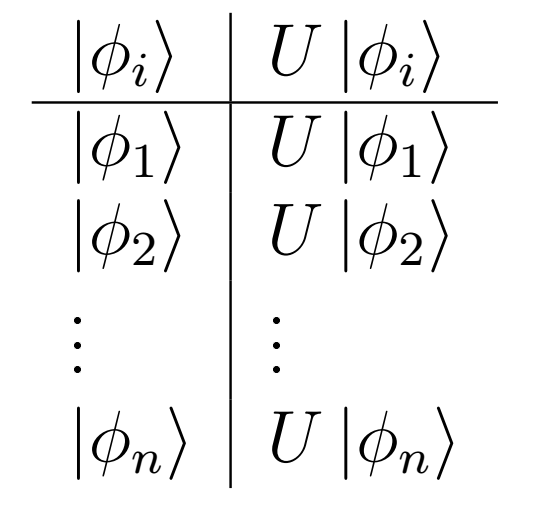

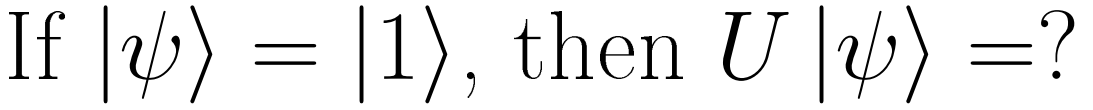

## Testing Basis

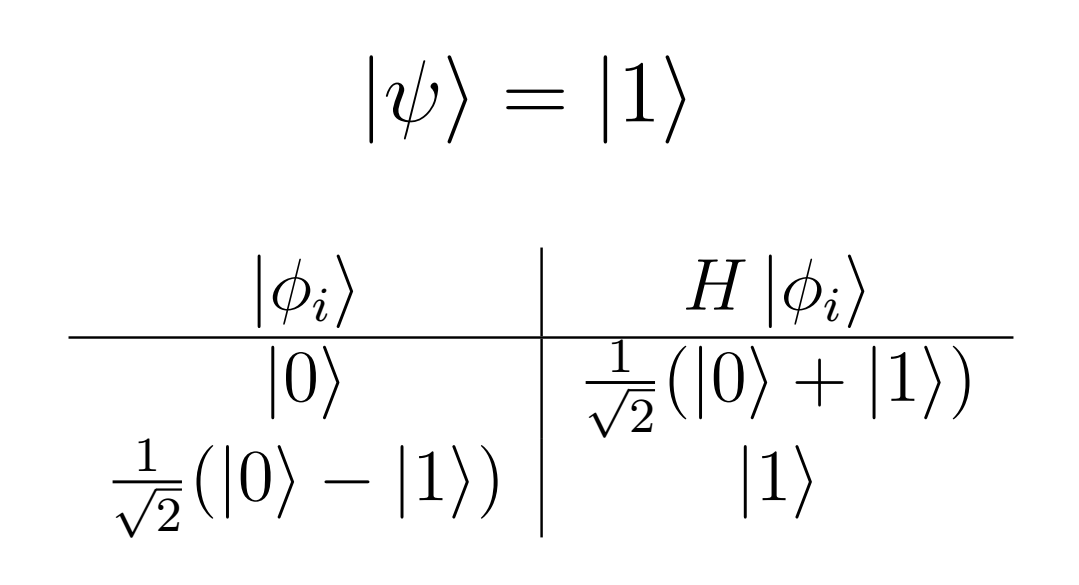

# The Circuit

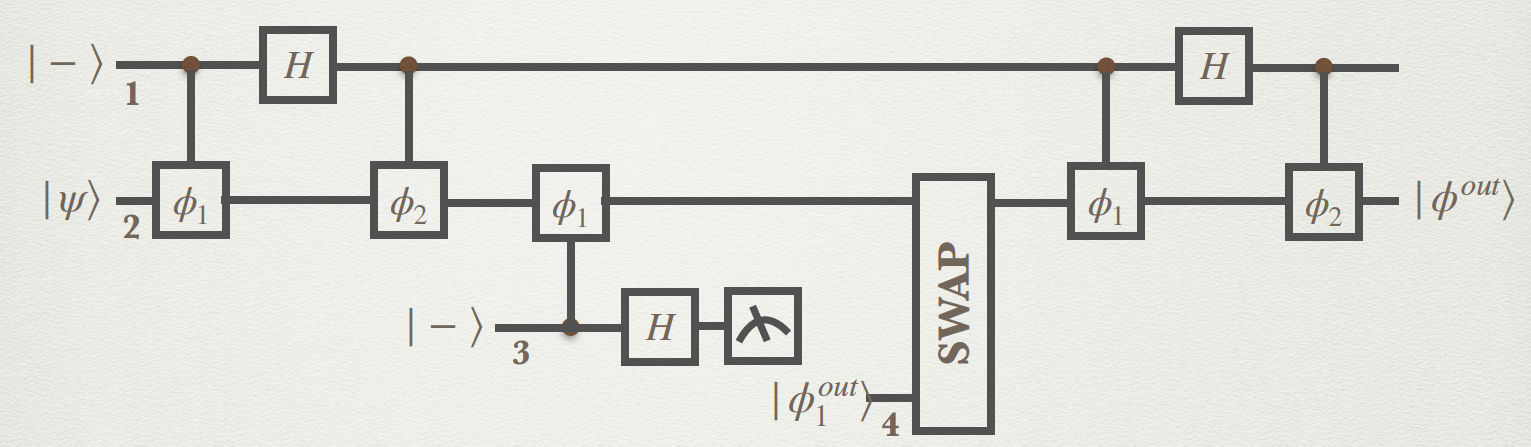

## QPU Schematic

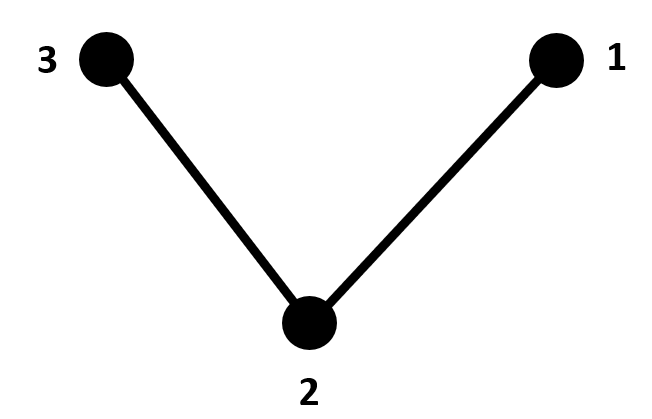

# <font color='red'>The Code</font> 

### Importing Packages

In [1]:
from pyquil import Program
from pyquil.parameters import Parameter, quil_sin, quil_cos
from pyquil.quil import DefGate
from pyquil.api import WavefunctionSimulator, get_qc, local_qvm
from pyquil.gates import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

import numpy as np

### Defining the architecture used

In [ ]:
circuit = Program()

qc_name = 'Aspen-4-16Q-A'
qc = get_qc(qc_name,as_qvm=True)
qubits = qc.qubits()

### Choice of simulation parameter

In [3]:
#run = 0   ## for a single run with fix angles
run = 1 ## for multiple runs varying one angle

### Input parameters and output states

In [4]:
## Input parameters
theta1_in_ref = 0
theta1_out_ref = theta1_in_ref-np.pi/2

if run == 0:
    theta2_in_ref = np.pi/4
    theta2_out_ref = theta2_in_ref-np.pi/2
elif run == 1:
    theta2_in_ref  = circuit.declare('theta2_in','REAL') # Memory for theta
    theta2_out_ref = circuit.declare('theta2_out','REAL')
    sample = 200 # number of samples for theta

## Parameters for simulation
creg = circuit.declare("ro","BIT",1) # declare only 1 bit of storage for the measurement
num_shots = 100                     # number of repetitions of the measurements

### Function for the controlled-rotation

In [5]:
def controlled_reflection(circ,angle,control,target):
    circ += RZ(3*np.pi/2,target)
    circ += RY(2*angle,target)
    circ += CNOT(control,target)
    circ += RY(-2*angle,target)
    circ += RZ(-np.pi,target)
    circ += CNOT(control,target)
    circ += RZ(-np.pi/2,target)
    circ += PHASE(3*np.pi/2,control)
    
    return circ

### The circuit

In [6]:
## Initialisation

# Top qubit
circuit += X(2)
circuit += H(2) # changing |0> to |-> state
# Input qubit
circuit += X(1)
# Lower qubit 
circuit += I(0)

## Controlled reflection
circuit = controlled_reflection(circuit,theta1_in_ref,2,1)
circuit += H(2)
circuit = controlled_reflection(circuit,theta2_in_ref,2,1)

## SWAP part
circuit += RY(theta1_in_ref,0)
circuit += X(0)
circuit += SWAP(0,1)

## Controlled reflection out
circuit = controlled_reflection(circuit,theta1_out_ref,2,1)
circuit += H(2)
circuit = controlled_reflection(circuit,theta2_out_ref,2,1)

## Measurement
circuit += MEASURE(qubits[1],creg)

print(circuit)

circuit.wrap_in_numshots_loop(num_shots) # wrap the circuit in a loop to measure num_shots times 
executable = qc.compile(circuit)         # compile the circuit

DECLARE theta2_in REAL[1]
DECLARE theta2_out REAL[1]
DECLARE ro BIT[1]
X 2
H 2
X 1
I 0
RZ(3*pi/2) 1
RY(0) 1
CNOT 2 1
RY(0) 1
RZ(-pi) 1
CNOT 2 1
RZ(-pi/2) 1
PHASE(3*pi/2) 2
H 2
RZ(3*pi/2) 1
RY(2*theta2_in) 1
CNOT 2 1
RY(-2*theta2_in) 1
RZ(-pi) 1
CNOT 2 1
RZ(-pi/2) 1
PHASE(3*pi/2) 2
RY(0) 0
X 0
SWAP 0 1
RZ(3*pi/2) 1
RY(-pi) 1
CNOT 2 1
RY(pi) 1
RZ(-pi) 1
CNOT 2 1
RZ(-pi/2) 1
PHASE(3*pi/2) 2
H 2
RZ(3*pi/2) 1
RY(2*theta2_out) 1
CNOT 2 1
RY(-2*theta2_out) 1
RZ(-pi) 1
CNOT 2 1
RZ(-pi/2) 1
PHASE(3*pi/2) 2
MEASURE 1 ro



### Measurement for a single run

In [7]:
if run == 0:
    
    result = qc.run(executable)              # execute the circuit and store the measurements in result
    
    ## Analysis
    compt = sum(result[i][0] == 1 for i in range(len(result)))                                               
    print("Fidelity of the state: ", compt/len(result)*100)

### Measurements for several runs

In [8]:
if run==1:
    parametric_measurements = []
    fidelity = []
    angles = np.linspace(0,2 * np.pi, sample)
    
    for theta2_in in angles:
        theta2_out = theta2_in + np.pi/2
        # Get the results of the run with the value we want to execute with
        bitstrings = qc.run(executable, {'theta2_in': [theta2_in],'theta2_out': [theta2_out]})
        # Store our results
        parametric_measurements.append(bitstrings)
        # Analysis
        compt = sum(bitstrings[i][0] == 1 for i in range(len(bitstrings)))
        fidelity.append(compt/len(bitstrings)*100)

#print(parametric_measurements)
print(fidelity)

[100.0, 100.0, 100.0, 98.0, 94.0, 89.0, 95.0, 95.0, 89.0, 79.0, 76.0, 84.0, 82.0, 79.0, 67.0, 70.0, 63.0, 66.0, 56.00000000000001, 52.0, 60.0, 43.0, 57.99999999999999, 46.0, 47.0, 51.0, 56.00000000000001, 41.0, 53.0, 52.0, 49.0, 60.0, 61.0, 56.00000000000001, 63.0, 64.0, 73.0, 72.0, 73.0, 85.0, 84.0, 79.0, 84.0, 92.0, 95.0, 99.0, 98.0, 100.0, 99.0, 100.0, 100.0, 100.0, 100.0, 98.0, 96.0, 93.0, 92.0, 90.0, 86.0, 93.0, 83.0, 72.0, 75.0, 69.0, 69.0, 61.0, 62.0, 62.0, 60.0, 62.0, 62.0, 52.0, 53.0, 52.0, 53.0, 49.0, 54.0, 47.0, 55.00000000000001, 49.0, 55.00000000000001, 63.0, 59.0, 55.00000000000001, 76.0, 67.0, 76.0, 76.0, 77.0, 77.0, 90.0, 88.0, 89.0, 92.0, 98.0, 94.0, 96.0, 100.0, 100.0, 100.0, 100.0, 99.0, 97.0, 98.0, 96.0, 95.0, 88.0, 87.0, 85.0, 81.0, 80.0, 75.0, 75.0, 69.0, 65.0, 67.0, 56.99999999999999, 61.0, 57.99999999999999, 55.00000000000001, 61.0, 56.99999999999999, 44.0, 50.0, 52.0, 40.0, 52.0, 56.00000000000001, 62.0, 56.99999999999999, 60.0, 63.0, 55.00000000000001, 66.0, 7

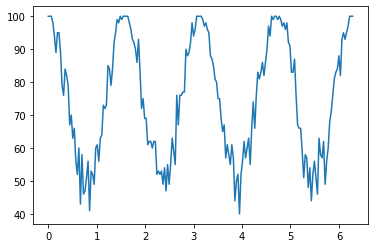

In [9]:
plt.figure()
plt.plot(angles,fidelity)